In [39]:
!pip install python-docx

In [40]:
!pip install lime

#### Libraries

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import random
random.seed(33)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import recall_score, make_scorer, f1_score, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from lime import lime_tabular, submodular_pick
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, LassoCV
import gspread
from google.auth import default
from google.colab import auth
import docx
from PIL import Image
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression, SelectKBest

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Loading dataset from Drive

In [6]:
# Authenticate
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [7]:
sheetID = '1-rVhHaHLcFvikSjKXOR6jCOW-zdpdNAnLWXzJMAzyRg'

In [8]:
worksheet = gc.open_by_key(sheetID).sheet1

In [9]:
# Get all records from the sheet
data = worksheet.get_all_records()
df = pd.DataFrame(data)
df.head()

,X (seconds),Y (hours),Z (minutes)
0,10,23,45
1,5,3,12
2,30,40,5
3,45,17,33
4,2,45,56


In [10]:
df.shape

(1049, 3)

In [11]:
# Create a new column 'Check' with initial value as 'Correct'
df['Check'] = 'Correct'

# Update 'Check' to 'Incorrect' if any of the conditions fail
df.loc[~df['X (seconds)'].between(0, 59, inclusive='both'), 'Check'] = 'Incorrect'
df.loc[~df['Y (hours)'].between(0, 47, inclusive='both'), 'Check'] = 'Incorrect'
df.loc[~df['Z (minutes)'].between(0, 59, inclusive='both'), 'Check'] = 'Incorrect'

df = df[df['Check'] != 'Incorrect']
print(df.shape)

(1005, 4)


##### There were 44 incorrect entries generated by Grok.

In [12]:
df.drop(columns=['Check'], inplace=True)

In [13]:
df['Time'] = df['Y (hours)'].apply(lambda x: 'Incorrect' if x >= 24 else 'Correct')

In [14]:
y_counts = df['Time'].value_counts()
print(y_counts)

Time
Incorrect    592
Correct      413
Name: count, dtype: int64


In [15]:
df.shape

(1005, 4)

#### Mapping to Time to binary values

In [16]:
df['Time'] = df['Time'].map({'Correct': 0, 'Incorrect': 1})

In [17]:
df.head()

,X (seconds),Y (hours),Z (minutes),Time
0,10,23,45,0
1,5,3,12,0
2,30,40,5,1
3,45,17,33,0
4,2,45,56,1


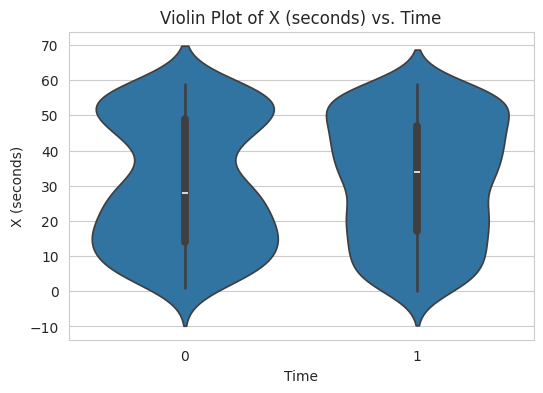

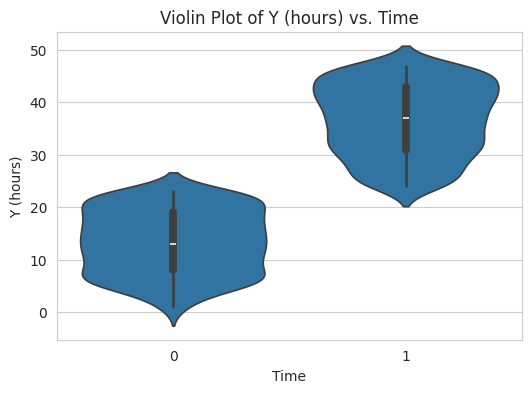

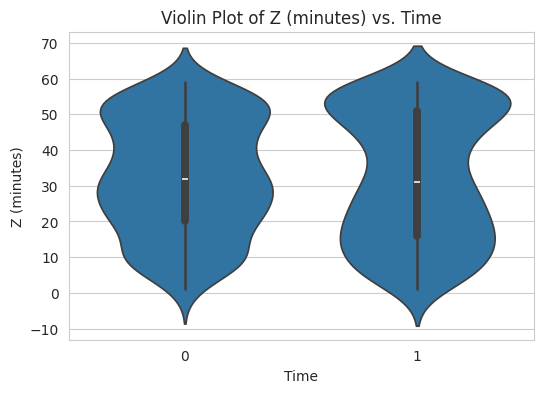

In [21]:
# @title Violin Plots
for column in df.columns:
  if column != 'Time':  # Exclude 'Time' column itself
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='Time', y=column, data=df)
    plt.title(f'Violin Plot of {column} vs. Time')
    plt.show()

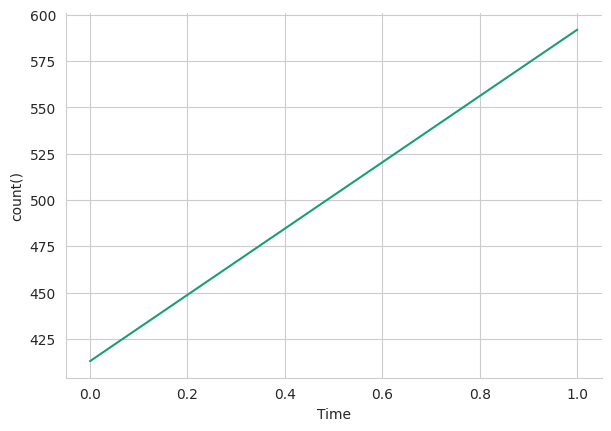

In [20]:
# @title Time vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Time'}, axis=1)
              .sort_values('Time', ascending=True))
  xs = counted['Time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(6, 4.2), layout='constrained')
df_sorted = df.sort_values('Time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('count()')

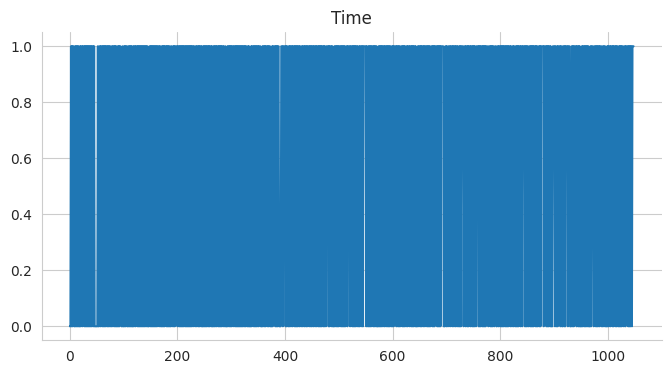

In [133]:
# @title Time

from matplotlib import pyplot as plt
df['Time'].plot(kind='line', figsize=(8, 4), title='Time')
plt.gca().spines[['top', 'right']].set_visible(False)

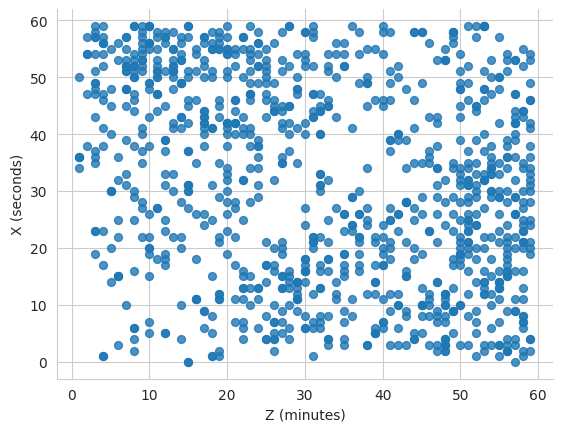

In [134]:
# @title Z (minutes) vs X (seconds)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Z (minutes)', y='X (seconds)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

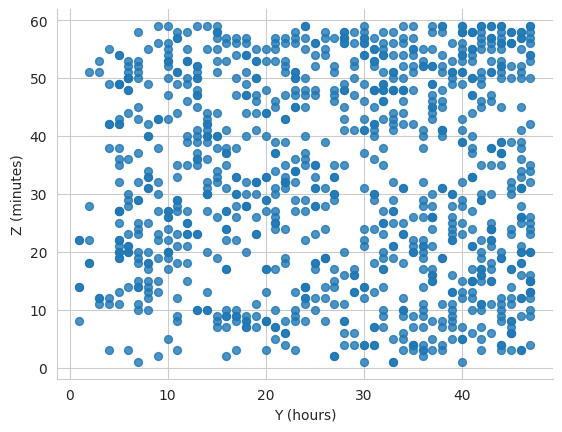

In [135]:
# @title Y (hours) vs Z (minutes)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Y (hours)', y='Z (minutes)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

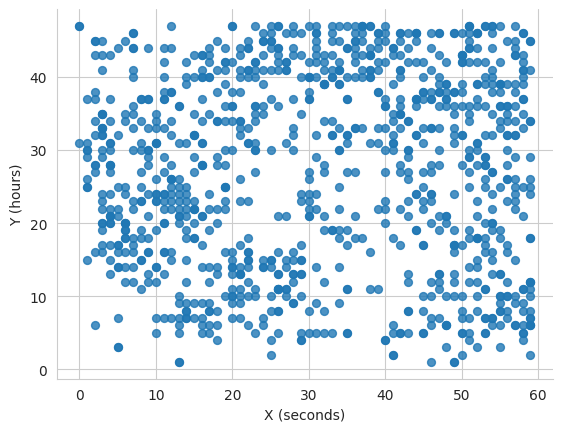

In [136]:
# @title X (seconds) vs Y (hours)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='X (seconds)', y='Y (hours)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

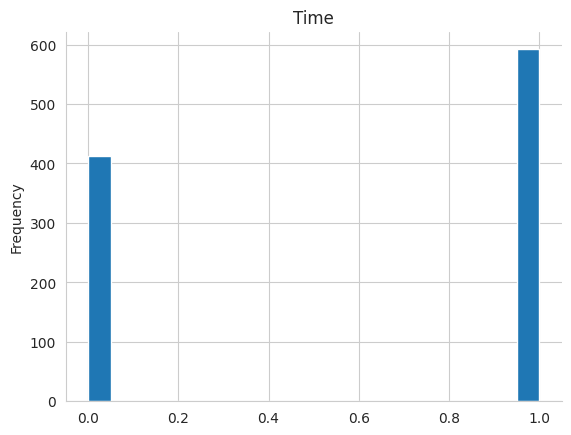

In [137]:
# @title Time

from matplotlib import pyplot as plt
df['Time'].plot(kind='hist', bins=20, title='Time')
plt.gca().spines[['top', 'right',]].set_visible(False)

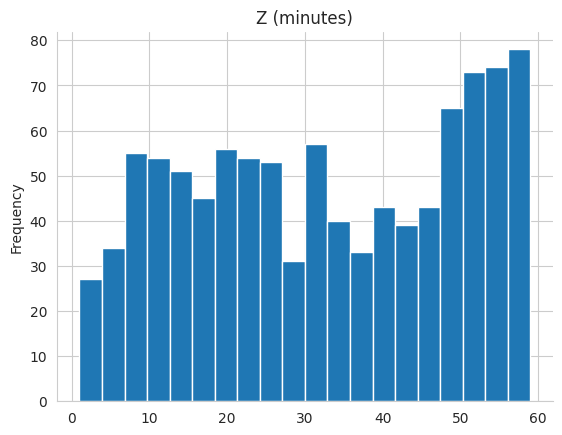

In [138]:
# @title Z (minutes)

from matplotlib import pyplot as plt
df['Z (minutes)'].plot(kind='hist', bins=20, title='Z (minutes)')
plt.gca().spines[['top', 'right',]].set_visible(False)

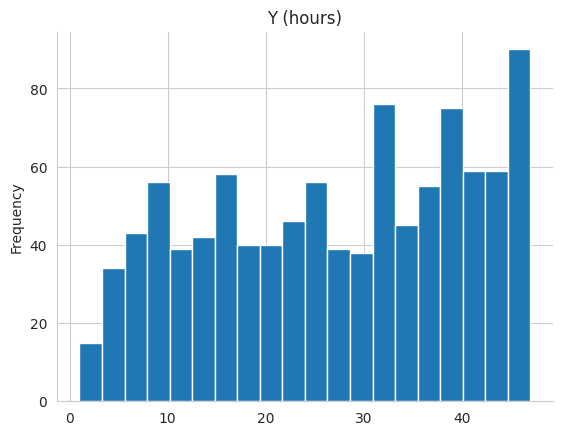

In [139]:
# @title Y (hours)

from matplotlib import pyplot as plt
df['Y (hours)'].plot(kind='hist', bins=20, title='Y (hours)')
plt.gca().spines[['top', 'right',]].set_visible(False)

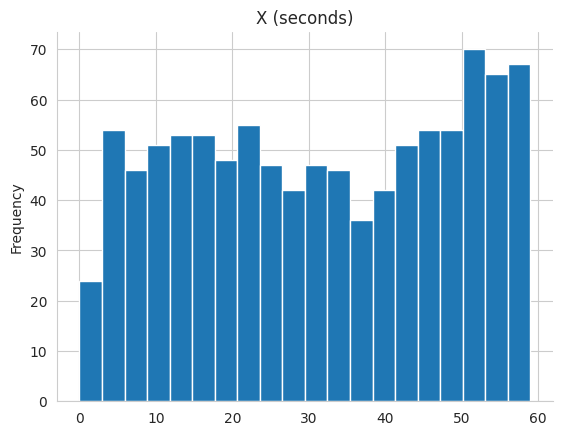

In [140]:
# @title X (seconds)

from matplotlib import pyplot as plt
df['X (seconds)'].plot(kind='hist', bins=20, title='X (seconds)')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Heatmap

<Axes: >

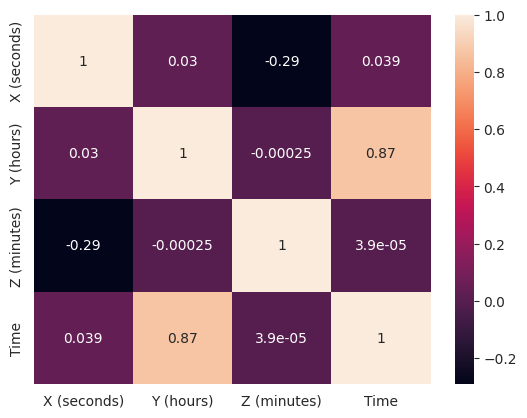

In [141]:
sns.heatmap(df.corr(), annot=True)

#### Mesh Plot

In [142]:
x = df['X (seconds)'].to_list()
y = df['Y (hours)'].to_list()
z = df['Z (minutes)'].to_list()
fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50,)], layout=go.Layout(scene=dict(xaxis_title='X (Seconds)', yaxis_title='Y (Hours)', zaxis_title='Z (Minutes)')))
fig.show()

#### Surface Plot

In [143]:
fig = go.Figure(data=[go.Surface(z=df.values)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), contours_x=dict(show=True, usecolormap=True,
                                  highlightcolor="pink", project_x=True), )
fig.update_layout(title='Surface Plot', autosize=False,
                  scene_camera_eye=dict(y=2.87,z=-0.64,x=-1),
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

#### Sentences from the generated story

In [18]:
path = "/content/drive/MyDrive/dm634/story.docx"
doc = docx.Document(path)

sentences = []

for para in doc.paragraphs:
  para_sentences = [sentence.strip() for sentence in para.text.split('.') if sentence.strip()]
  sentences.extend(para_sentences)

sentences = [sentence + '.' if not sentence.endswith('.') else sentence for sentence in sentences]

In [19]:
random.shuffle(sentences)

# Assign sentences to DataFrame
df['Sentence'] = [sentences[i % len(sentences)] for i in range(len(df))]
df.head(10)

,X (seconds),Y (hours),Z (minutes),Time,Sentence
0,10,23,45,0,There's a tent where visitors can hear stories...
1,5,3,12,0,Memory and time together weave the story of a ...
2,30,40,5,1,Every clock they produce is a testament to the...
3,45,17,33,0,The Guild collaborates with scientists to stud...
4,2,45,56,1,A community leader shares how organizing local...
5,55,10,20,0,"The challenge of time theft in workplaces, whe..."
6,1,30,4,1,"Residents go to bed grateful, knowing that the..."
7,27,42,11,1,The advent of 5G and beyond has made real-time...
8,8,15,58,0,Time-based technologies like automated reminde...
9,14,7,29,0,"The Time Network, a marvel of modern technolog..."


#### Create images

In [154]:
def create_daylight_sky():
    # Daylight has more white (255) and lighter shades
    return Image.fromarray(np.random.randint(150, 256, size=(108, 108), dtype=np.uint8))

def create_moonlight_sky():
    # Moonlight has darker shades with some lighter spots
    base = np.random.randint(0, 100, size=(108, 108), dtype=np.uint8)
    moon = np.random.randint(150, 256, size=(1, 1), dtype=np.uint8)
    base[random.randint(0, 6), random.randint(0, 6)] = moon[0][0]  # Simulate moon
    return Image.fromarray(base)

def create_cloudy_sky():
    # Cloudy sky has varied shades but generally lighter than moonlight
    return Image.fromarray(np.random.randint(100, 200, size=(108, 108), dtype=np.uint8))

In [155]:
output_dir = '/content/drive/MyDrive/dm634/skyImages/'
!mkdir -p {output_dir}

In [156]:
for i in range(336):
    # Daylight
    img = create_daylight_sky()
    img.save(f'{output_dir}daylight_{i}.png')

    # Moonlight
    img = create_moonlight_sky()
    img.save(f'{output_dir}moonlight_{i}.png')

    # Cloudy
    img = create_cloudy_sky()
    img.save(f'{output_dir}cloudy_{i}.png')

### Text Classification

In [20]:
classificationDf = df[['Sentence','Time']]

In [21]:
classificationDf.head()

,Sentence,Time
0,There's a tent where visitors can hear stories...,0
1,Memory and time together weave the story of a ...,0
2,Every clock they produce is a testament to the...,1
3,The Guild collaborates with scientists to stud...,0
4,A community leader shares how organizing local...,1


In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Time'], test_size=0.3, random_state=33)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [23]:
model = LogisticRegression(random_state=33)
model.fit(X_train_vectorized, y_train)

y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.11      0.18       133
           1       0.57      0.95      0.72       169

    accuracy                           0.58       302
   macro avg       0.61      0.53      0.45       302
weighted avg       0.60      0.58      0.48       302



In [24]:
print(len(y_pred))

302


In [25]:
print(y_pred[301])

1


In [26]:
print(y_pred[45])

0


In [27]:
# LIME explainer
explainer = LimeTextExplainer(class_names=['Correct Time', 'Incorrect Time'])
def predict_proba(texts):
  return model.predict_proba(vectorizer.transform(texts))

# Explain an instance
idx = 301
exp = explainer.explain_instance(X_test.iloc[idx], predict_proba, num_features=10)

# Display the explanation
print('Document id: %d' % idx)
print('Probability(Time) =', model.predict_proba(X_test_vectorized[idx])[0, 1])
print('True class: %s' % y_test.iloc[idx])
print("Explanation for class Time:")
exp.show_in_notebook(text=X_test.iloc[idx], predict_proba=predict_proba)

Document id: 301
Probability(Time) = 0.5498315416275791
True class: 1
Explanation for class Time:


In [28]:
idx = 45
exp = explainer.explain_instance(X_test.iloc[idx], predict_proba, num_features=10)

# Display the explanation
print('Document id: %d' % idx)
print('Probability(Time) =', model.predict_proba(X_test_vectorized[idx])[0, 1])
print('True class: %s' % y_test.iloc[idx])
print("Explanation for class Time:")
exp.show_in_notebook(text=X_test.iloc[idx], predict_proba=predict_proba)

Document id: 45
Probability(Time) = 0.48506678893504607
True class: 0
Explanation for class Time:


In [29]:
sp_obj = submodular_pick.SubmodularPick(explainer,
                                        X_test.tolist(),
                                        predict_proba,
                                        sample_size=20,  # Number of instances to explain
                                        num_features=10,  # Number of features to show in each explanation
                                        num_exps_desired=5)  # Number of diverse explanations

In [35]:
print(sp_obj.V)
print(sp_obj.explanations)
print(sp_obj.sp_explanations)

[9, 1, 8, 0, 6]
[<lime.explanation.Explanation object at 0x7920ba52c8d0>, <lime.explanation.Explanation object at 0x7920ba49bc10>, <lime.explanation.Explanation object at 0x7920ba577090>, <lime.explanation.Explanation object at 0x7920ba4f5fd0>, <lime.explanation.Explanation object at 0x7920ba576e90>, <lime.explanation.Explanation object at 0x7920ba4b5a50>, <lime.explanation.Explanation object at 0x7920ba49b3d0>, <lime.explanation.Explanation object at 0x7920ba4f7290>, <lime.explanation.Explanation object at 0x7920ba53fc90>, <lime.explanation.Explanation object at 0x7920ba590b10>, <lime.explanation.Explanation object at 0x7920ba577550>, <lime.explanation.Explanation object at 0x7920ba4667d0>, <lime.explanation.Explanation object at 0x7920ba4b6710>, <lime.explanation.Explanation object at 0x7920ba48be10>, <lime.explanation.Explanation object at 0x7920ba444210>, <lime.explanation.Explanation object at 0x7920ba467290>, <lime.explanation.Explanation object at 0x7920ba6da510>, <lime.explanat

In [37]:
print(f"Selected {len(sp_obj.sp_explanations)} diverse explanations:")
for i, idx in enumerate(sp_obj.V):  # Use .V to get the indices
    print(f"\nExplanation {i + 1}:")
    print(f"Predicted Probability(Time) = {model.predict_proba(X_test_vectorized[idx].reshape(1, -1))[0, 1]}")
    print(f"True class: {y_test.iloc[idx]}")
    sp_obj.sp_explanations[i].show_in_notebook(text=X_test.iloc[idx])

Output hidden; open in https://colab.research.google.com to view.

### Regression Model

In [61]:
rmDf = df[['X (seconds)','Y (hours)','Z (minutes)','Time']]
rmDf.head()

,X (seconds),Y (hours),Z (minutes),Time
0,10,23,45,0
1,5,3,12,0
2,30,40,5,1
3,45,17,33,0
4,2,45,56,1


In [62]:
rmDf['Time'] = rmDf['Y (hours)'] * 60 * 60 + rmDf['Z (minutes)'] * 60 + rmDf['X (seconds)']
rmDf.head()

,X (seconds),Y (hours),Z (minutes),Time
0,10,23,45,85510
1,5,3,12,11525
2,30,40,5,144330
3,45,17,33,63225
4,2,45,56,165362


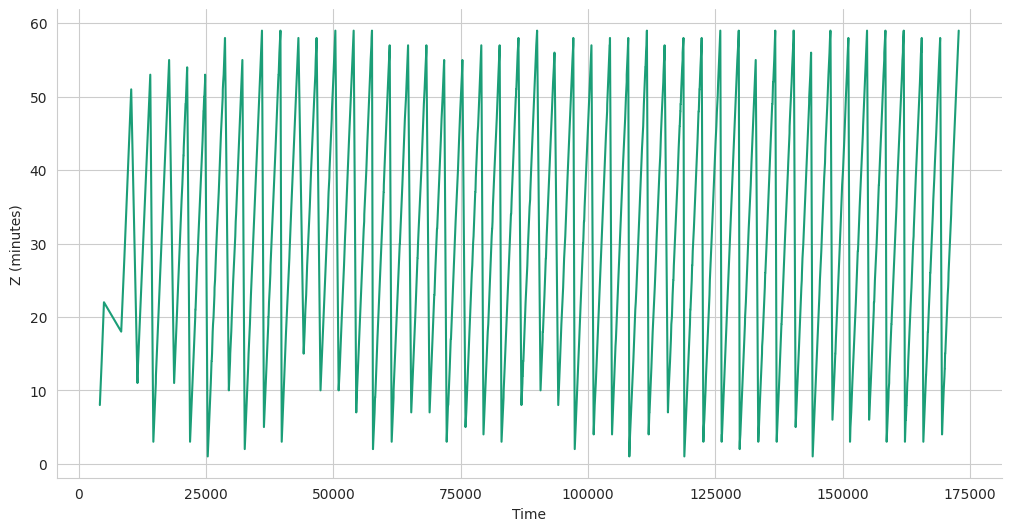

In [84]:
# @title Time vs Z (minutes)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['Z (minutes)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rmDf.sort_values('Time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('Z (minutes)')

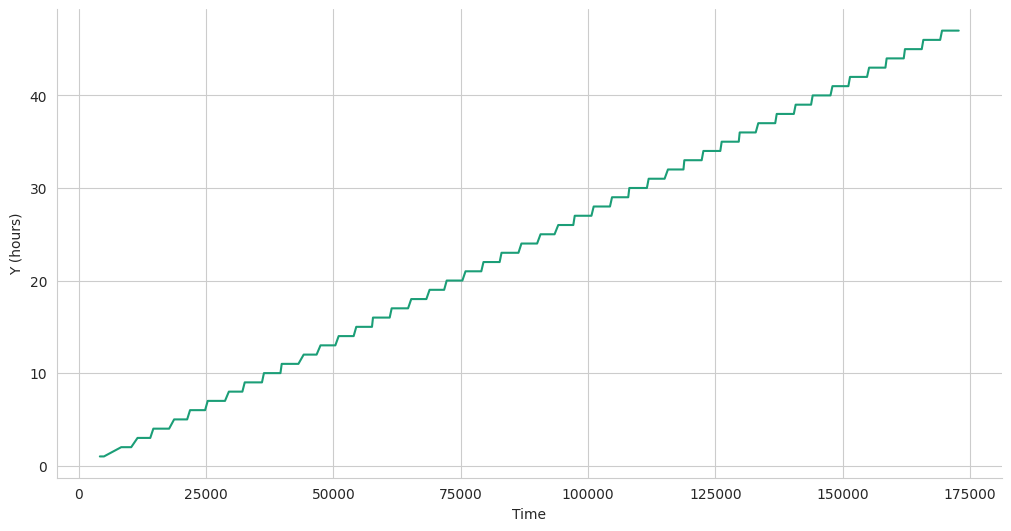

In [83]:
# @title Time vs Y (hours)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['Y (hours)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rmDf.sort_values('Time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('Y (hours)')

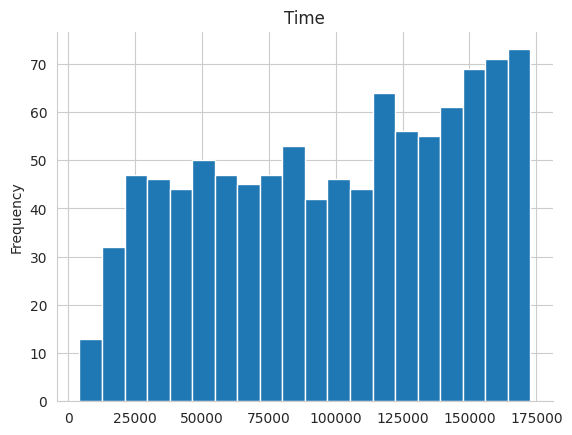

In [82]:
# @title Time

from matplotlib import pyplot as plt
rmDf['Time'].plot(kind='hist', bins=20, title='Time')
plt.gca().spines[['top', 'right',]].set_visible(False)

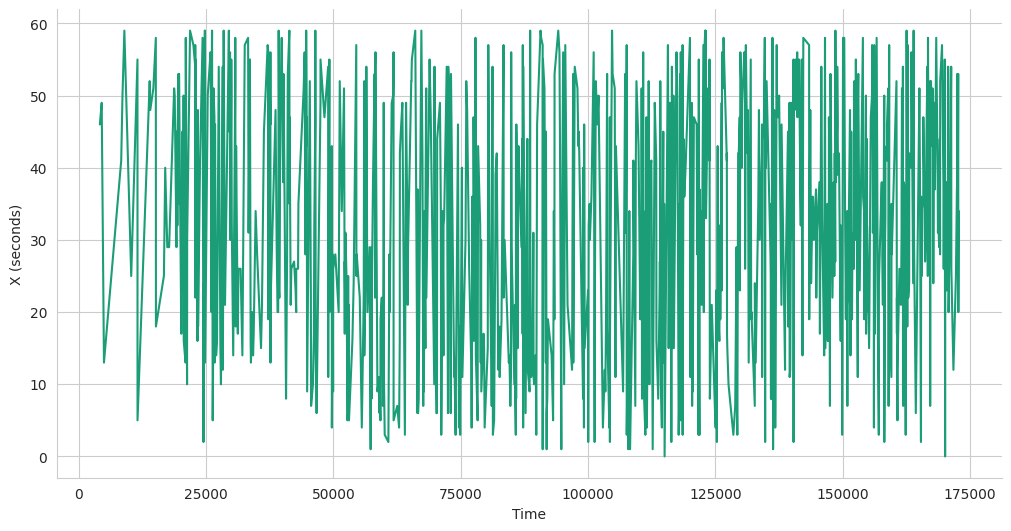

In [81]:
# @title Time vs X (seconds)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['X (seconds)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rmDf.sort_values('Time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('X (seconds)')

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [97]:

lasso = LassoCV(cv=5, random_state=33)
lasso.fit(X_train_scaled, y_train)

selector = SelectFromModel(lasso, prefit=True)
X_train_lasso_selected = selector.transform(X_train_scaled)
X_test_lasso_selected = selector.transform(X_test_scaled)


dt = DecisionTreeRegressor(random_state=33)
dt.fit(X_train_lasso_selected, y_train)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2

# Evaluate Lasso
y_pred_lasso = lasso.predict(X_test_scaled)
mse_lasso, r2_lasso = evaluate_model(y_test, y_pred_lasso)

# Evaluate Decision Tree
y_pred_dt = dt.predict(X_test_lasso_selected)
mse_dt, r2_dt = evaluate_model(y_test, y_pred_dt)

print(f"Lasso Regressor - MSE: {mse_lasso}, R2: {r2_lasso}")
print(f"Decision Tree with Feature Selection - MSE: {mse_dt}, R2: {r2_dt}")

# Step 2: Use LIME for Explanations
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
selected_feature_names = [name for idx, name in enumerate(feature_names) if selector.get_support()[idx]]

# LIME for Lasso
explainer_lasso = LimeTabularExplainer(X_train_scaled, mode="regression", feature_names=feature_names)
exp_lasso = explainer_lasso.explain_instance(X_test_scaled[0], lasso.predict, num_features=5)

# LIME for Decision Tree
explainer_dt = LimeTabularExplainer(X_train_lasso_selected, mode="regression", feature_names=selected_feature_names)
exp_dt = explainer_dt.explain_instance(X_test_lasso_selected[0], dt.predict, num_features=5)

# Step 3: Compare Explanations
print("\nLIME Explanation for Lasso Regressor:")
for feature, weight in exp_lasso.as_list():
    print(f"{feature}: {weight}")

print("\nLIME Explanation for Decision Tree:")
for feature, weight in exp_dt.as_list():
    print(f"{feature}: {weight}")

# You can visually compare by showing the explanations
exp_lasso.show_in_notebook(show_table=True, show_all=False)
exp_dt.show_in_notebook(show_table=True, show_all=False)

Output hidden; open in https://colab.research.google.com to view.